# Using Bayes Traits

In [323]:
import subprocess, numpy as np, ete3, sys, tqdm, subprocess, pandas as pd
from scipy import sparse as sp
from scipy.stats import chi2
from Bio import Phylo, Nexus
import pandas as pd
import tailer as tl
import io
from IPython.display import display

In [214]:
# create nexus tree (cluster) - precalc
out_path = "/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/const.nex"
n_ants = 4
order = np.load("/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/statistics_joint_phy/order.npy")
phen_path = ("/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/MetaData.csv")
Phen = pd.read_csv(phen_path, index_col=0, sep='\t').replace({'I':'S'}).replace({'S':0,'R':1,'s':0,'r':1})
Phen = Phen[[col for col in Phen.columns if 'SIR' in col]].loc[order]
Phen.columns = [x.split(' ')[0] for x in Phen.columns]
def TakeitPair(n_kmers=None, append=False, R=False):
    X = sp.load_npz("/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/statistics_joint_phy/SampleTableUnique.npz")
    with open(out_path, 'w') as file:
        if R:
            file.write(' '.join(Phen.columns.tolist() + list(map(str, range(n_kmers))))+'\n')
        if append:
            prefix = "#NEXUS\n Begin data;\n \tDimensions NTAX=%s NCHAR=%s;\n \tMatrix\n" % (len(order), n_kmers)
            file.write(prefix)
        for i, name in tqdm.tqdm(enumerate(order), total=len(order)):
            if n_kmers != None:
                file.write(name + ' ' +' '.join(Phen.iloc[i].astype(str)[:2].tolist()) + '\n')
            else:
                file.write(name + ' ' +' '.join(Phen.iloc[i].astype(str).tolist()) + '\n')
        if append:
            suffix = "\t;\nEnd;\nBegin BayesPhylogenies;\nModel M1P;\nIterations 10;\n\nAutoRun;\nend;"
            file.write(suffix)

def Takeit(n_kmers=None, append=True, R=True):
    X = sp.load_npz("/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/statistics_joint_phy/SampleTableUnique.npz")
    with open(out_path, 'w') as file:
        if R:
            file.write(' '.join(Phen.columns.tolist() + list(map(str, range(n_kmers))))+'\n')
        if append:
            prefix = "#NEXUS\n Begin data;\n \tDimensions NTAX=%s NCHAR=%s;\n \tMatrix\n" % (len(order), n_kmers)
            file.write(prefix)
        for i, name in tqdm.tqdm(enumerate(order), total=len(order)):
            if n_kmers != None:
                file.write(name + ' ' +' '.join(Phen.iloc[i].astype(str).tolist() + 
                        list(np.array(X[i, :n_kmers].astype(np.int8).todense())[0].astype(str))) + '\n')
            else:
                file.write(name + ' ' +' '.join(Phen.iloc[i].astype(str).tolist() + 
                        list(np.array(X[i].astype(np.int8).todense())[0].astype(str))) + '\n')
        if append:
            suffix = "\t;\nEnd;\nBegin BayesPhylogenies;\nModel M1P;\nIterations 10;\n\nAutoRun;\nend;"
            file.write(suffix)

In [215]:
# create nexus tree (cluster)
TakeitPair(1, False, False)
BayesPhylo_path = "/home/kishonylab/Gal/Resources/BayesPhylogenies-1.1/BayesPhylogenies"
subprocess.call(BayesPhylo_path + ' ' + out_path, shell=True)

100%|██████████| 1046/1046 [00:00<00:00, 3727.08it/s]


0

In [216]:
fake = out_path+".trees"
fake = open(fake, 'r').readlines()

In [52]:
"""
tree_path = "/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/phy.tre"
newick = open(tree_path).read()
for i,name in enumerate(labels):    
    newick = newick.replace(','+str(i)+':', ','+name+':')
    newick = newick.replace('('+str(i)+':', '('+name+':')
tree_path = "/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/phy.tre.fix"
print(newick, file=open(tree_path,'w'))
"""

'\ntree_path = "/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/phy.tre"\nnewick = open(tree_path).read()\nfor i,name in enumerate(labels):    \n    newick = newick.replace(\',\'+str(i)+\':\', \',\'+name+\':\')\n    newick = newick.replace(\'(\'+str(i)+\':\', \'(\'+name+\':\')\ntree_path = "/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/phy.tre.fix"\nprint(newick, file=open(tree_path,\'w\'))\n'

In [217]:
tree_path = "/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/phy.tre.fix"
nex_path = "/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/Phylo.nexsus"
newick = open(tree_path).read()
labels = order.tolist()
for i,name in enumerate(labels):    
    newick = newick.replace(name+':', str(i)+':')
fake[-2] = '\t\ttree tree1 = ' + newick
print(''.join(fake), file=open(nex_path,'w'))

In [107]:
def tree_to_constraints(tree_file_path, constraints_file_path, dependant=False, MCMC=False, itNum=1000, tol=0.001):
    """receives a tree newic file and writes to constraits file a list of each ancestor's descendants. returns dictionary- ancestor_num:leaves_list"""
    import ete3
    ancestor_num_to_leaves={}
    with open(tree_file_path, 'r') as tree:
        t=tree.read()
        t=ete3.Tree(t)
    with open(constraints_file_path, 'w') as constraints_file:
        num=0
        constraints_file.write(('2' if not dependant else '3')+'\n'+
                               ('1' if not MCMC else '2')+'\n') # for discrete
        constraints_file.write('ScaleTrees\n')
        if itNum is not None: constraints_file.write('MLMaxEval '+str(itNum)+'\n')
        if tol is not None: constraints_file.write('MLTol '+str(tol)+'\n')
        
        for node in t.traverse():
            if node.is_leaf():
                continue
            constraints_file.write('AddTag '+str(num)+' = ')
            leaves=node.get_leaves()
            leaves=[x.name for x in leaves]
            ancestor_num_to_leaves[num]=leaves
            for leaf in leaves:
                constraints_file.write(leaf+' ')
            constraints_file.write('\n')
            constraints_file.write('AddNode '+str(num)+' '+str(num)+'\n')
            num+=1
        #constraints_file.write('AddNode '+str(num)+' '+str(num)+'\n')
        constraints_file.write('run')
    return ancestor_num_to_leaves

In [93]:
#TODO limit iteration number
#test on small trees

In [116]:
const_path = nex_path +'.const'
ancestor_num_to_leaves_dict = tree_to_constraints(tree_path, const_path, dependant=False, MCMC=False, itNum=1000, tol=0.001)
BayesTraits_path = "/home/kishonylab/Gal/Resources/BayesTraitsV3.0.1-Linux-Threaded/BayesTraitsV3"
subprocess.call(' '.join([BayesTraits_path, nex_path, out_path, '<', const_path]), shell=True)

1

In [117]:
#this is what the bayestraits output looks like
out_path_log = out_path+'.Log.txt'
file = open(out_path_log)
lastLines = tl.tail(file,1) #to read last 15 lines, change it to any value.
LL = float(lastLines[0][:100].split('\t')[1])
LL

-348.944889

In [114]:
const_path = nex_path +'.const'
ancestor_num_to_leaves_dict = tree_to_constraints(tree_path, const_path, dependant=True, MCMC=False, itNum=1000, tol=0.001)
BayesTraits_path = "/home/kishonylab/Gal/Resources/BayesTraitsV3.0.1-Linux-Threaded/BayesTraitsV3"
subprocess.call(' '.join([BayesTraits_path, nex_path, out_path, '<', const_path]), shell=True)

0

In [115]:
#this is what the bayestraits output looks like
out_path_log = out_path+'.Log.txt'
file = open(out_path_log)
lastLines = tl.tail(file,1) #to read last 15 lines, change it to any value.
LLD = float(lastLines[0][:100].split('\t')[1])
LLD

-348.944889

# Using Bayes Traits efficiantly

In [332]:
dat_path = '/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/test'
nex_path = dat_path +'.trees'

In [365]:
import ete3
import scipy.sparse as sp
t = ete3.Tree()
t.populate(500)
for i,node in enumerate(t.traverse()): 
    node.name = '_'+str(i)+'_'
    node.dat = sp.csr_matrix(np.random.randint(2, size=5))

In [366]:
# preprocessing 1: Given an ete tree, convert to Bayesphylogeny format

# create a fake nexus tree
def PrintDat(tree, out_path, dat_idx = None, append=False):
    with open(out_path, 'w') as file:
        if append:
            prefix = "#NEXUS\n Begin data;\n \tDimensions NTAX=%s NCHAR=%s;\n \tMatrix\n" % (len(t), len(dat_idx))
            file.write(prefix)
        for leaf in tree:
            leaf_dat = '1' if dat_idx is None else ' '.join((leaf.dat[0, dat_idx].toarray()[0].astype(str)))
            file.write(str(leaf.name) + ' '+ leaf_dat +'\n')
        if append:
            suffix = "\t;\nEnd;\nBegin BayesPhylogenies;\nModel M1P;\nIterations 10;\n\nAutoRun;\nend;"
            file.write(suffix)
    return


PrintDat(t, dat_path, [0], append=True)
BayesPhylo_path = "/home/kishonylab/Gal/Resources/BayesPhylogenies-1.1/BayesPhylogenies"
subprocess.call(BayesPhylo_path + ' ' + dat_path, shell=True)

0

In [367]:
# paste real tree onto it
newick = t.write()
newick = newick.replace(")1:1", "):1")
for i,leaf in enumerate(t):    
    newick = newick.replace(leaf.name+':', str(i)+':')
    
fake = open(nex_path, 'r').readlines()
fake[-2] = '\t\ttree tree1 = ' + newick +'\n'
print(''.join(fake), file=open(nex_path,'w'))

In [418]:
# preprocessing 2: prep activation files
def tree_to_constraints(tree, output_path, dependant=False, MCMC=False, itNum=1000, tol=0.001):
    """receives a tree newic file and writes to constraits file a list of each ancestor's descendants. returns dictionary- ancestor_num:leaves_list"""
    ancestor_num_to_leaves={}
    with open(output_path, 'w') as constraints_file:
        constraints_file.write(('2' if not dependant else '3')+'\n'+
                               ('1' if not MCMC else '2')+'\n') # for discrete
        constraints_file.write('ScaleTrees\n')
        if itNum is not None: constraints_file.write('MLMaxEval '+str(itNum)+'\n')
        if tol is not None: constraints_file.write('MLTol '+str(tol)+'\n')
        
        for node in tree.traverse():
            if node.is_leaf():
                continue
            constraints_file.write('AddTag '+node.name+' = ')
            for leaf in node:
                constraints_file.write(leaf.name+' ')
            constraints_file.write('\n')
            constraints_file.write('AddNode '+node.name+' '+node.name+'\n')
        constraints_file.write('run')

indep_path = nex_path +'_independant.const'
tree_to_constraints(t, indep_path, dependant=False, MCMC=False, itNum=100, tol=0.001)
dep_path = nex_path +'_dependant.const'
tree_to_constraints(t, dep_path, dependant=True, MCMC=False, itNum=100, tol=0.001)

In [419]:
# work 1: run both models for each pair 
BayesTraits_path = "/home/kishonylab/Gal/Resources/BayesTraitsV3.0.1-Linux-Threaded/BayesTraitsV3"
def BayesTraits(tree, phen_ind, gene_ind):
    # print a new dat file
    PrintDat(tree, dat_path, [phen_ind, gene_ind], append=False)
    # run independant
    subprocess.call(' '.join([BayesTraits_path, nex_path, dat_path, '<', indep_path]), shell=True)
    lastLine = tl.tail(open(dat_path+'.Log.txt'), 1)
    H_0 = float(lastLine[0][:100].split('\t')[1])
    
    # run dependant
    subprocess.call(' '.join([BayesTraits_path, nex_path, dat_path, '<', dep_path]), shell=True)
    lastLine = tl.tail(open(dat_path+'.Log.txt'), 1)
    H_1 = float(lastLine[0][:100].split('\t')[1])
    
    # get LR score
    LR = 2*(H_1-H_0)
    # get return pval
    pval = chi2(4).sf(LR)
    return LR, pval, H_1, H_0

In [425]:
BayesTraits(t, 3, 2)

(1.875490000000127, 0.7586459540353505, -690.243028, -691.180773)

# Other stuff

In [384]:
df_len = len(ancestral_df.columns) - 5
params = (n_kmers + n_ants)
df = ancestral_df.values[0, 4:-1].reshape((df_len//2, 2)).argmax(axis=1).reshape((df_len//2//params, params))
display(df)

array([[0, 0, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 1, 0],
       ..., 
       [0, 1, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 0]])

In [497]:
#this is the walk on the tree- counting the number of changes
def get_all_unique_paths_on_tree(tree_file_path, leaves_to_ancestor_dict, phen_ind, ancestral_df):
    """returns all paths from root to leafs on the tree"""
    import ete3
    with open(tree_file_path, 'r') as tree:
        t=tree.read()
        t=ete3.Tree(t)
    hist_kmers = []
    get_all_unique_paths_on_tree_aux(t, leaves_to_ancestor_dict, phen_ind, ancestral_df, hist_kmers)
    hist_kmers = np.array(hist_kmers)
    bins = lambda x: np.bincount(x[x>=0], minlength=4)
    contingencies = np.apply_along_axis(bins, 0 ,hist_kmers)
    return contingencies
                
def get_all_unique_paths_on_tree_aux(tree_object, leaves_to_ancestor_dict, phen_ind, ancestral_df, hist_kmers):
    #if(tree_object.is_leaf()==True):
    #    return
    leaves=tree_object.get_leaves()
    leaves=[x.name for x in leaves]
    for cur_node in tree_object.traverse():
        if cur_node.is_leaf(): continue
        if cur_node.is_root(): continue
        node = leaves_to_ancestor_dict[' '.join([x.name for x in cur_node.get_leaves()])]
        prev_node = leaves_to_ancestor_dict[' '.join([x.name for x in cur_node.up.get_leaves()])]
        
        phen_state =  ancestral_df[node, phen_ind].copy()
        gene_state =  ancestral_df[node, n_ants:].copy()
        prev_phen_state =  ancestral_df[prev_node, phen_ind].copy()
        prev_gene_state =  ancestral_df[prev_node, n_ants:].copy()
        
        same = np.logical_and(prev_phen_state == phen_state, np.equal(prev_gene_state, gene_state))
        hist = 2*phen_state + gene_state
        hist[same] = -1
        hist_kmers.append(hist)

In [469]:
tables = get_all_unique_paths_on_tree(tree_path, inv_map, 0, df)

In [495]:
# new_events = np.concatenate([[0], np.argwhere(np.any(np.diff(phen_kmer_tup, axis=0) != 0, axis=1)).T[0] + 1])
from scipy.stats.distributions import hypergeom, norm
Res = pd.DataFrame(index=range(n_kmers))
colnames = ['pval', 'ods', 'SE']
for ant, ant_name in tqdm.tqdm(enumerate(Phen.columns),total=n_ants):
    tables = (get_all_unique_paths_on_tree(tree_path, ancestor_num_to_leaves_dict, ant, ancestral_df))
    No_Phen_no_Kmer, Has_Kmer_no_Phen, Has_Phen_no_Kmer, Has_Kmer_and_Phen = tables
    
    # if ant zero's add 0.5 to all cells
    append = ~((No_Phen_no_Kmer > 0) * (Has_Kmer_no_Phen>0) * (Has_Kmer_and_Phen>0) * (Has_Phen_no_Kmer>0)) * 0.5
    Has_Kmer_and_Phen = Has_Kmer_and_Phen + append
    Has_Kmer_no_Phen = Has_Kmer_no_Phen + append
    Has_Phen_no_Kmer = Has_Phen_no_Kmer + append
    No_Phen_no_Kmer = No_Phen_no_Kmer + append
    
    PopulationSize = tables.sum(axis=0)
    Has_Kmer = tables[1::2].sum(axis=0)
    Has_Phen = tables[-2:].sum(axis=0)

    less = np.vectorize(hypergeom.cdf)(Has_Kmer_and_Phen, PopulationSize, Has_Kmer, Has_Phen)
    greater = np.vectorize(hypergeom.cdf)(Has_Kmer_no_Phen, PopulationSize, Has_Kmer, PopulationSize - Has_Phen)
    pvalue = less * greater
    log_ods = np.log(np.divide((Has_Kmer_and_Phen * No_Phen_no_Kmer), (Has_Kmer_no_Phen * Has_Phen_no_Kmer)))
    se = np.sqrt((1/Has_Kmer_and_Phen) + (1/Has_Kmer_no_Phen) + (1/Has_Phen_no_Kmer) + (1/No_Phen_no_Kmer))
    CurrRes = pd.DataFrame([pvalue, log_ods, se], index=[ant_name + '_' + x for x in colnames]).T
    Res = Res.join(CurrRes)

100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


In [496]:
Res

,AZM SIR_pval,AZM SIR_ods,AZM SIR_SE,CFM SIR_pval,CFM SIR_ods,CFM SIR_SE,CIP SIR_pval,CIP SIR_ods,CIP SIR_SE,CRO SIR_pval,CRO SIR_ods,CRO SIR_SE
0,1.000000e+00,0.730888,2.018904,1.000000,0.631272,2.030407,1.000000,-0.096460,2.012040,1.0,0.000000,2.828427
1,1.295443e-01,-2.242687,1.572006,0.161943,-2.092290,1.584777,0.295759,-1.468026,1.564383,1.0,0.000000,2.190890
2,3.442623e-01,-1.779489,1.655336,0.378378,-1.652923,1.668321,0.535714,-0.979424,1.647560,1.0,0.000000,2.309401
3,1.904036e-03,-1.112792,0.380319,0.331622,0.101400,0.430938,0.000096,1.148092,0.304733,1.0,-0.103541,2.005754
4,1.000000e+00,0.730888,2.018904,1.000000,0.631272,2.030407,1.000000,-0.096460,2.012040,1.0,0.000000,2.828427
5,2.621936e-03,-3.132207,1.481810,0.007658,-2.894636,1.492370,0.081798,1.745239,1.101455,1.0,0.000000,2.065591
6,3.442623e-01,-1.779489,1.655336,0.378378,-1.652923,1.668321,0.535714,-0.979424,1.647560,1.0,0.000000,2.309401
7,3.442623e-01,-1.779489,1.655336,0.378378,-1.652923,1.668321,0.535714,-0.979424,1.647560,1.0,0.000000,2.309401
8,1.867677e-04,3.399827,1.458137,0.001789,3.035111,1.466088,0.176609,0.807091,0.690084,1.0,-0.315081,2.031780
9,1.443770e-05,-2.202151,0.626000,0.000005,-3.660606,1.440254,0.095499,0.438913,0.308099,1.0,0.050858,2.008462


# Using MaxPasimony instead

In [16]:
t = ete3.Tree(tree_path)
order = np.load("/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/statistics_joint/order.npy").tolist()

In [21]:
children = [np.array(X[order.index('ECDC_SI13_074')].todense().astype(np.int8))[0] , np.array(X[order.index('ECDC_AT13_506')].todense().astype(np.int8))[0]]

In [23]:
children

[array([1, 0, 0, ..., 1, 0, 0], dtype=int8),
 array([1, 0, 0, ..., 1, 0, 0], dtype=int8)]

In [22]:
res = children[0].copy()
eq = np.equal(*children)
res[children[0] == 2] = children[1][children[0] == 2]
res[children[1] == 2] = children[0][children[1] == 2]
res[(children[0] != 2) & (children[1] != 2) & ~eq] = 2

In [13]:
X = sp.load_npz("/media/kishonylab/ACBA3EA9BA3E6FC6/Alice_datasets/Neisseria/alice_15/statistics_joint/SampleTableUnique.npz")

In [282]:
def MaxParsimony(X, Tree, tip_row_dict):
    # 2 represents {0,1} set
    wrap = lambda x: X[tip_row_dict[x.name]] if x.is_leaf() else np.array(x.genotype.todense().astype(np.int8))[0]
    from numpy.random import choice
    tree_len = 0
    for x in Tree.traverse(): tree_len +=1
    for i, node in tqdm.tqdm(enumerate(Tree.traverse('postorder')), total=tree_len, desc='Ancestral Reconstruction: 1st pass'):
        if node.is_leaf(): continue
        node.name = i
        children = [wrap(c) for c in node.children]
        res = children[0].copy()
        eq = np.equal(*children)
        res[children[0] == 2] = children[1][children[0] == 2] # 2 is the union {0,1}
        res[children[1] == 2] = children[0][children[1] == 2]
        res[(children[0] != 2) & (children[1] != 2) & ~eq] = 2
        node.genotype = sp.csr_matrix(res)

    post = Tree.traverse('preorder')
    root = next(post)
    root.random = (wrap(root.genotype) == 2)
    root.genotype[root.genotype == 2] = np.random.choice([1,0], size=(root.genotype == 2).sum())
    for node in tqdm.tqdm(post, total=tree_len-1, desc='Ancestral Reconstruction: 2nd pass'):
        if node.is_leaf(): continue
        parent_ = wrap(node.up.genotype)
        node_ = wrap(node.genotype)
        res = node_.copy()
        eq = np.equal(node_, parent_)
        # res[parent == 2] = node[parent == 2] # no such thing. parents are constant at this point
        res[node_ == 2] = parent_[node_ == 2]
        node.random = (node.up.random) & (node_ == 2) # these are unstable positions - will not be counted
        #disjoint = (parent_ != 2) & (node_ != 2) & ~eq
        #res[disjoint] = np.random.choice([1,0], size=disjoint.sum())
        node.genotype = sp.csr_matrix(res)

    return Tree

In [259]:
#this is the walk on the tree- counting the number of changes
def get_all_unique_paths_on_tree_2(t, phen_ind):
    """returns all paths from root to leafs on the tree"""
    hist_kmers = get_all_unique_paths_on_tree_aux_2(t, phen_ind)
    hist_kmers = np.array(hist_kmers)
    bins = lambda x: np.bincount(x[x>=0], minlength=4)
    contingencies = np.apply_along_axis(bins, 0 ,hist_kmers)
    return contingencies
   
def get_all_unique_paths_on_tree_aux_2(tree_object, phen_ind):
    hist_kmers = []
    wrap = lambda x: np.array(x.todense().astype(np.int8))[0]
    getarr = lambda x: np.concatenate([Phen.loc[x.name].tolist() ,wrap(X[order.index(x.name)])]) if x.is_leaf() else wrap(x.genotype)
    if(tree_object.is_leaf()==True): return
    leaves=tree_object.get_leaves()
    leaves=[x.name for x in leaves]
    for cur_node in tree_object.traverse():
        # if cur_node.is_leaf(): continue
        if cur_node.is_root(): continue
        node = getarr(cur_node)
        prev_node = getarr(cur_node.up)
        
        if not cur_node.is_leaf() and cur_node.random[phen_ind]: continue
        phen_state =  node[phen_ind]
        gene_state =  node[n_ants:]
        prev_phen_state =  prev_node[phen_ind]
        prev_gene_state =  prev_node[n_ants:]
        
        same = np.logical_and(prev_phen_state == phen_state, np.equal(prev_gene_state, gene_state))
        hist = 2*phen_state + gene_state
        hist[same] = -1 # marked as invalid
        if not cur_node.is_leaf(): hist[cur_node.random[n_ants:]] = -1
        hist_kmers.append(hist)

In [290]:
from scipy.stats.distributions import hypergeom
from statsmodels.stats.multitest import multipletests

def PhyFisher(X, Phenotype, Tree):
    """
        Assuming X is s_k csr scipy sparse mat
        Phenotype is s_p pandas mat, ordered by X with index of sample names
        Tree is ete3 tree with tips matching Phenotype index
        subgroup is a list of leaves from Phenotype index
    """
    
    X = sp.hstack([sp.csr_matrix(Phenotype.values), X], format='csr')
    tip_to_row = {name:row for row,name in enumerate(Phenotype.index)}
    t = Tree.copy()
    
    """
    if subgroup: # reduce tree
        t.prune([x for x in t.get_leaf_names() if x not in subgroup])
        Phenotype = Phenotype.loc[[x for x in Phenotype.index if x in subgroup]]
    """
       
    t = MaxParsimony(X, t, tip_to_row) # ancestral reconstraction
    
    Res = pd.DataFrame(index=range(X.shape[1]))
    colnames = ['pval', 'pval_corr', 'ods', 'SE']    
    for ant, ant_name in tqdm.tqdm(enumerate(Phen.columns[:-1]),total=n_ants,desc="fishering..."):
        tables = (get_all_unique_paths_on_tree_2(t, ant))
        No_Phen_no_Kmer, Has_Kmer_no_Phen, Has_Phen_no_Kmer, Has_Kmer_and_Phen = tables

        # if ant zero's add 0.5 to all cells
        append = ~((No_Phen_no_Kmer > 0) * (Has_Kmer_no_Phen>0) * (Has_Kmer_and_Phen>0) * (Has_Phen_no_Kmer>0)) * 0.5
        Has_Kmer_and_Phen = Has_Kmer_and_Phen + append
        Has_Kmer_no_Phen = Has_Kmer_no_Phen + append
        Has_Phen_no_Kmer = Has_Phen_no_Kmer + append
        No_Phen_no_Kmer = No_Phen_no_Kmer + append

        PopulationSize = tables.sum(axis=0)
        Has_Kmer = tables[1::2].sum(axis=0)
        Has_Phen = tables[-2:].sum(axis=0)

        less = np.vectorize(hypergeom.cdf)(Has_Kmer_and_Phen, PopulationSize, Has_Kmer, Has_Phen)
        greater = np.vectorize(hypergeom.cdf)(Has_Kmer_no_Phen, PopulationSize, Has_Kmer, PopulationSize - Has_Phen)
        pvalue = less * greater
        pvalue_corr = multipletests(pvalue, alpha=0.05, method='bonferroni', returnsorted=False)[1]
        log_ods = np.log(np.divide((Has_Kmer_and_Phen * No_Phen_no_Kmer), (Has_Kmer_no_Phen * Has_Phen_no_Kmer)))
        se = np.sqrt((1/Has_Kmer_and_Phen) + (1/Has_Kmer_no_Phen) + (1/Has_Phen_no_Kmer) + (1/No_Phen_no_Kmer))
        CurrRes = pd.DataFrame([pvalue, pvalue_corr, log_ods, se], index=[ant_name + '_' + x for x in colnames]).T
        Res = Res.join(CurrRes)
        
    return Res

In [291]:
res = PhyFisher(X, Phen, t)

Ancestral Reconstruction: 1st pass:   0%|          | 0/2091 [00:00<?, ?it/s]/home/kishonylab/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:226: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  " != instead.", SparseEfficiencyWarning)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [294]:
np.equal(*children)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [278]:
x.name

NameError: name 'x' is not defined

In [238]:
# new_events = np.concatenate([[0], np.argwhere(np.any(np.diff(phen_kmer_tup, axis=0) != 0, axis=1)).T[0] + 1])
from scipy.stats.distributions import hypergeom
from statsmodels.stats.multitest import multipletests

Res = pd.DataFrame(index=range(X.shape[1]))
colnames = ['pval', 'pval_corr', 'ods', 'SE']
for ant, ant_name in tqdm.tqdm(enumerate(Phen.columns[:-1]),total=n_ants):
    tables = (get_all_unique_paths_on_tree_2(t, ant))
    No_Phen_no_Kmer, Has_Kmer_no_Phen, Has_Phen_no_Kmer, Has_Kmer_and_Phen = tables
    
    # if ant zero's add 0.5 to all cells
    append = ~((No_Phen_no_Kmer > 0) * (Has_Kmer_no_Phen>0) * (Has_Kmer_and_Phen>0) * (Has_Phen_no_Kmer>0)) * 0.5
    Has_Kmer_and_Phen = Has_Kmer_and_Phen + append
    Has_Kmer_no_Phen = Has_Kmer_no_Phen + append
    Has_Phen_no_Kmer = Has_Phen_no_Kmer + append
    No_Phen_no_Kmer = No_Phen_no_Kmer + append
    
    PopulationSize = tables.sum(axis=0)
    Has_Kmer = tables[1::2].sum(axis=0)
    Has_Phen = tables[-2:].sum(axis=0)

    less = np.vectorize(hypergeom.cdf)(Has_Kmer_and_Phen, PopulationSize, Has_Kmer, Has_Phen)
    greater = np.vectorize(hypergeom.cdf)(Has_Kmer_no_Phen, PopulationSize, Has_Kmer, PopulationSize - Has_Phen)
    pvalue = less * greater
    pvalue_corr = multipletests(pvalue, alpha=0.05, method='bonferroni', returnsorted=False)[1]
    log_ods = np.log(np.divide((Has_Kmer_and_Phen * No_Phen_no_Kmer), (Has_Kmer_no_Phen * Has_Phen_no_Kmer)))
    se = np.sqrt((1/Has_Kmer_and_Phen) + (1/Has_Kmer_no_Phen) + (1/Has_Phen_no_Kmer) + (1/No_Phen_no_Kmer))
    CurrRes = pd.DataFrame([pvalue, pvalue_corr, log_ods, se], index=[ant_name + '_' + x for x in colnames]).T
    Res = Res.join(CurrRes)

 75%|███████▌  | 3/4 [00:52<00:17, 17.60s/it]


In [242]:
Res

,AZM_pval,AZM_pval_corr,AZM_ods,AZM_SE,CFM_pval,CFM_pval_corr,CFM_ods,CFM_SE,CIP_pval,CIP_pval_corr,CIP_ods,CIP_SE
0,1.000000e+00,1.000000,1.374318,2.029614,1.000000e+00,1.000000,2.433613,2.105965,1.000000,1.0,-0.510826,2.052641
1,2.115385e-01,1.000000,-2.472930,1.669132,9.677419e-02,1.000000,-3.532226,1.761180,0.650000,1.0,-0.587787,1.697056
2,2.115385e-01,1.000000,-2.472930,1.669132,9.677419e-02,1.000000,-3.532226,1.761180,0.650000,1.0,-0.587787,1.697056
3,2.639666e-02,1.000000,-0.890910,0.425963,3.474905e-01,1.000000,0.000000,0.453163,0.004377,1.0,-1.383203,0.498708
4,4.789550e-02,1.000000,2.983756,1.587241,1.209677e-02,1.000000,4.043051,1.683772,0.433333,1.0,1.098612,1.616581
5,2.935010e-03,1.000000,-3.571543,1.530215,3.234432e-04,1.000000,-4.630838,1.630126,0.219088,1.0,1.550597,1.251838
6,2.115385e-01,1.000000,-2.472930,1.669132,9.677419e-02,1.000000,-3.532226,1.761180,0.650000,1.0,-0.587787,1.697056
7,4.789550e-02,1.000000,-2.983756,1.587241,1.209677e-02,1.000000,-4.043051,1.683772,0.544762,1.0,0.538997,1.492042
8,6.468133e-05,1.000000,4.082368,1.500889,3.496683e-06,0.158477,5.141664,1.602629,0.360112,1.0,0.646627,0.948911
9,2.673229e-02,1.000000,-1.375823,0.646516,8.716750e-04,1.000000,-2.921143,1.091076,0.379562,1.0,-0.117783,0.624466


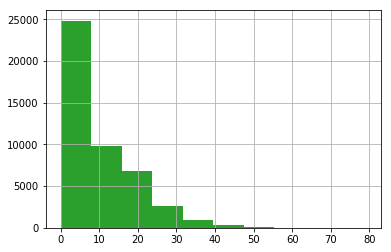

In [141]:
pd.Series(res.T.sum(axis=1)).hist()
import matplotlib.pylab as plt
plt.show()

In [298]:
t

Tree node '2090' (0x7f43ff45bb0)